<h1>Phase 1: Data Cleaning<h1>

In [1]:
# ==============================
#  1. IMPORT REQUIRED PACKAGES
# ==============================

import pandas as pd
from ftfy import fix_text
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import emoji
import re

# Ensure consistent language detection
DetectorFactory.seed = 0

In [2]:
# ===============================
#  2. LOAD DATA 
# ===============================

file_path = "C:/Users/mloai/Sentimental_Analysis_App/Data/SURVEY DATA SAMPLE.csv"

# Load the data
df = pd.read_csv(file_path, encoding='utf-8', dtype=str)

In [3]:
# ============================================
#  3. DATA CLEANING + LANGUAGE & EMOJI LOGIC
# ============================================


# === Extract emojis from text ===
def extract_emojis(text):
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

# === Clean text, detect language, and handle special cases ===
def clean_and_detect(text):
    if pd.isna(text):
        return "", "unknown", ""

    fixed = fix_text(text)
    extracted_emojis = extract_emojis(fixed)

    # Filter meaningless inputs: dots, dashes, empty space, etc.
    stripped = fixed.strip()
    if stripped in ['', '.', '..', '...', '-', '_']:
        return "", "unknown", extracted_emojis

    # Remove emojis to prepare for language detection
    text_without_emojis = ''.join(c for c in fixed if c not in emoji.EMOJI_DATA)
    text_stripped = text_without_emojis.strip()

    # If only emojis remain, label as 'emoji'
    if not text_stripped and extracted_emojis:
        lang = "emoji"
    else:
        try:
            lang = detect(text_stripped)
        except LangDetectException:
            lang = "unknown"

    return fixed.strip(), lang, extracted_emojis

In [4]:
# ===============================
#  4. INITIAL FILTERS
# ===============================

# === Apply cleaning and detection ===
df[['CLEAN_ANSWER', 'LANGUAGE', 'EMOJIS']] = df['ANSWER'].apply(lambda x: pd.Series(clean_and_detect(x)))

# Drop rows where LANGUAGE == 'unknown' (meaningless/blank responses)
df = df[df['LANGUAGE'] != 'unknown'].copy()


In [5]:
# =================================
#  5. COLUMN REMOVAL
# =================================

# === Drop unneeded columns ===
columns_to_drop = [
    'QUESTION_SEQ', 'QUESTION_SEQ_Q', 'QUESTION_TITLE',
    'CUSTOMER_MOBILE', 'EMPLOYEE_NO', 'REFERENCE_NO',
    'RESPONSE_STATUS', 'SESSION_ID','RESPONSE_ID',
    'SURVEY_TITLE', 'ANSWER'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [6]:
# Show results
print(df[[ 'CLEAN_ANSWER', 'LANGUAGE']].head())

                                        CLEAN_ANSWER LANGUAGE
0  التعاقد مع شركه ذات جوده ومعروفه وقويه في السو...       ar
1  اقترح في موضوع النوصيل المنزلي أن تتعاونوا مع ...       ar
2  إعطاء ثقة تامه إذا رغب العميل باخد خدمة الصيان...       ar
3                                         شكرا جزيلا       ar
4                             Availability  of stock       en


In [7]:
# ======================================
#  6. ACTIVITY SEGMENTATION 
# ======================================

# Check unique activity types in your data
print(df['ACTIVITY_NAME'].unique())

['Web Invoice' 'Store Invoice' 'Service Repair' 'Home Delivery']


In [8]:
activity_counts = df['ACTIVITY_NAME'].value_counts()
print(activity_counts)

ACTIVITY_NAME
Store Invoice     1799
Service Repair    1215
Home Delivery      810
Web Invoice        346
Name: count, dtype: int64


In [9]:
# === Define activities to separate ===
activities = ['Store Invoice', 'Service Repair', 'Home Delivery', 'Web Invoice']
activity_dfs = {}

In [10]:
for act in activities:
    subdf = df[df['ACTIVITY_NAME'] == act].copy()
    print(f"\nSample from '{act}':")
    print(subdf[['CLEAN_ANSWER', 'LANGUAGE', 'EMOJIS']].head())
    activity_dfs[act] = subdf

# ===============================
#  7. SAVE CLEANED FULL DATASET
# ===============================
# Save the full cleaned dataset
df.to_csv("cleaned_full_dataset.csv", index=False, encoding='utf-8-sig')
print(f"Saved full cleaned dataset with {len(df)} rows.")

# === Save each activity DataFrame as separate CSV ===
for act, subdf in activity_dfs.items():
    filename = f"cleaned_{act.replace(' ', '_').lower()}.csv"
    subdf.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"✅ Saved: {filename} ({len(subdf)} rows)")



Sample from 'Store Invoice':
                                        CLEAN_ANSWER LANGUAGE EMOJIS
1  اقترح في موضوع النوصيل المنزلي أن تتعاونوا مع ...       ar       
4                             Availability  of stock       en       
5                    IT personnel he is accomodating       en       
6  Your immediate delivery and your customer serv...       en       
7                                              Thank       en       

Sample from 'Service Repair':
                                         CLEAN_ANSWER LANGUAGE EMOJIS
2   إعطاء ثقة تامه إذا رغب العميل باخد خدمة الصيان...       ar       
23                                 خفض اسعار المنتجات       ar       
24  اكسترا منصتي الدائمة في شراء الاجهزة الالكترون...       ar       
25                                          شكراً لكم       ar       
26                                         كل شي رائع       ar       

Sample from 'Home Delivery':
                                         CLEAN_ANSWER LANGUAGE EMOJIS
33   

<h1>Phase 2: Sentiment Analysis on Cleaned Reviews<h1>
Using nlptown bert base multilingual model

In [ ]:
import re
import os
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [12]:
# === Load Sentiment Model ===
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [13]:
# === Neutral Keywords ===
neutral_keywords = {
    # Arabic
    "لا", "لا يوجد", "لا شي", "لايوجد","لا شيء", "مافي", "ولا شي", "ولا شيء", "ما في",
    # English
    "none", "nothing", "no", "n/a", "not applicable", "ok", "okay", "noted",
    "received", "confirmed", "yes", "done", "fine","Na","na"
}

# === Suggestive Critique Keywords ===
suggestive_critique_keywords = {
    "اقترح", "نقترح", "نوصي", "من الأفضل", "يفضل", "حبذا", "اقتراحي", "أوصي", "أقترح"
}

def is_strictly_neutral(text):
    if not text.strip():
        return False
    clean = text.strip().lower()
    if clean in neutral_keywords:
        return True
    words = re.findall(r'\w+', clean)
    return all(word in neutral_keywords for word in words)


# === Suggestive Critique Check ===
def is_suggestive_critique(text):
    text = text.strip()
    return any(kw in text for kw in suggestive_critique_keywords)

# === Sentiment Prediction Function ===
def predict_sentiment(text):
    if is_strictly_neutral(text):
        return "Neutral"

    if is_suggestive_critique(text):
        return "Neutral"  # or return "Neutral-Critique" if you want to track separately

    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=1).numpy()[0]

    negative = scores[0] + scores[1]
    neutral = scores[2]
    positive = scores[3] + scores[4]

    probs = {'Negative': negative, 'Neutral': neutral, 'Positive': positive}
    sentiment = max(probs, key=probs.get)
    
    return sentiment

In [14]:
# === Apply Sentiment Prediction ===
tqdm.pandas()
df['SENTIMENT'] = df['CLEAN_ANSWER'].progress_apply(predict_sentiment)

# === Preview Sample Output ===
print(df[['CLEAN_ANSWER', 'SENTIMENT']].sample(5))

100%|██████████| 4170/4170 [02:27<00:00, 28.35it/s]

                           CLEAN_ANSWER SENTIMENT
800                                Good  Positive
3583                           كله تمام  Positive
1846  وجود كفتريا تجعل التسوق فترة اطول  Negative
25                            شكراً لكم  Positive
3342                      احترمو العميل  Positive


In [15]:
# === Filter by Activity and Save ===
activities = ['Store Invoice', 'Service Repair', 'Home Delivery', 'Web Invoice']
activity_dfs = {act: df[df['ACTIVITY_NAME'] == act].copy() for act in activities}

# Save each to CSV
output_dir = "sentimented_outputs"
os.makedirs(output_dir, exist_ok=True)

for act, subdf in activity_dfs.items():
    filename = f"Sentimented_{act.replace(' ', '_').lower()}.csv"
    path = os.path.join(output_dir, filename)
    subdf.to_csv(path, index=False, encoding='utf-8-sig')
    print(f"Saved {path} ({len(subdf)} rows)")

Saved sentimented_outputs\Sentimented_store_invoice.csv (1799 rows)
Saved sentimented_outputs\Sentimented_service_repair.csv (1215 rows)
Saved sentimented_outputs\Sentimented_home_delivery.csv (810 rows)
Saved sentimented_outputs\Sentimented_web_invoice.csv (346 rows)


<h1>Phase 3: Sentiment Insights Report<h1>
Showcasing the data

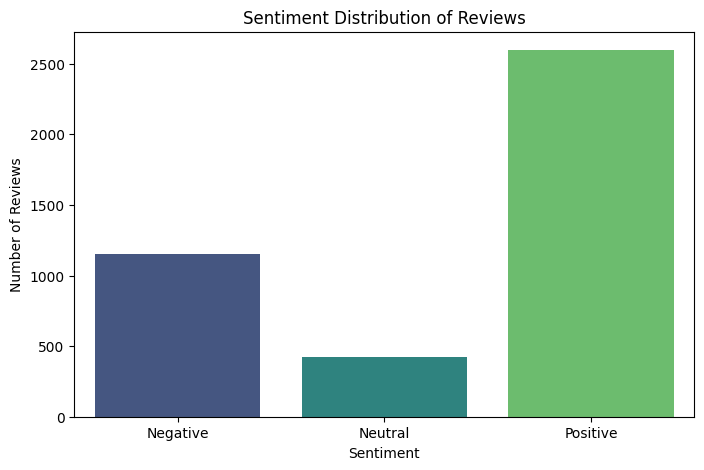

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each sentiment category
sentiment_counts = df['SENTIMENT'].value_counts().sort_index()

# Bar plot
plt.figure(figsize=(8,5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [37]:
percentages = sentiment_counts / sentiment_counts.sum() * 100
print(percentages)

SENTIMENT
Negative    27.577938
Neutral     10.143885
Positive    62.278177
Name: count, dtype: float64


In [18]:
df.to_csv('reviews_with_sentiment.csv', index=False, encoding='utf-8-sig')

In [19]:
# List of known activities
activities = ['Store Invoice', 'Service Repair', 'Home Delivery', 'Web Invoice']

# Create dictionary of DataFrames
activity_dfs = {act: df[df['ACTIVITY_NAME'] == act].copy() for act in activities}

# Save each activity data to separate CSV
for act, subdf in activity_dfs.items():
    filename = f"Sentimented_{act.replace(' ', '_').lower()}.csv"
    subdf.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"Saved {filename} ({len(subdf)} rows)")


Saved Sentimented_store_invoice.csv (1799 rows)
Saved Sentimented_service_repair.csv (1215 rows)
Saved Sentimented_home_delivery.csv (810 rows)
Saved Sentimented_web_invoice.csv (346 rows)


In [20]:
import pandas as pd

store_df = pd.read_csv('Sentimented_store_invoice.csv')
service_df = pd.read_csv('Sentimented_service_repair.csv')
home_df = pd.read_csv('Sentimented_home_delivery.csv')
web_df = pd.read_csv('Sentimented_web_invoice.csv')

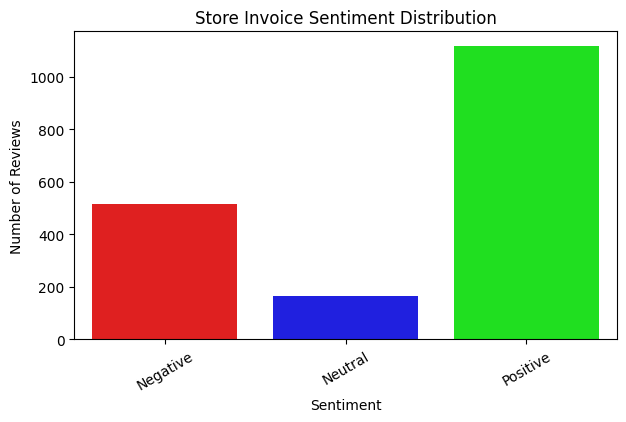

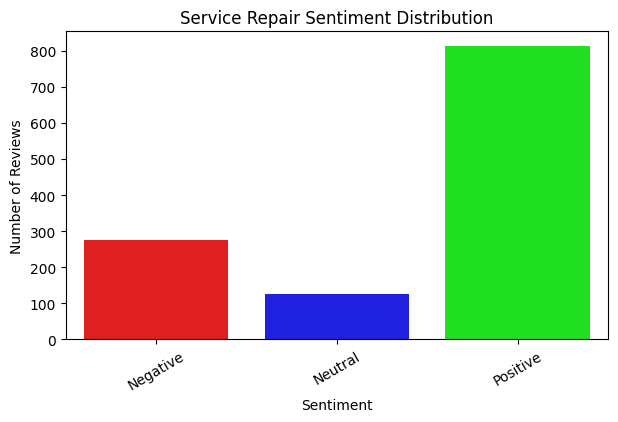

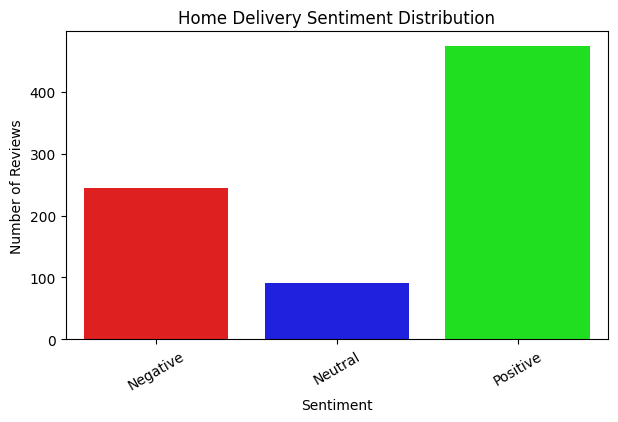

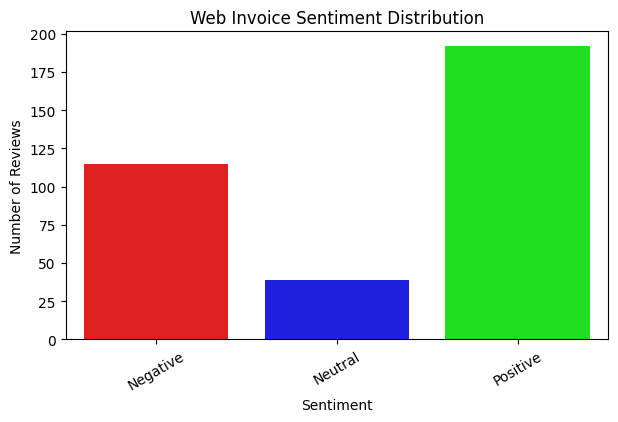

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


colors = {
   
    'Negative': '#FF0000',       # Red
    'Neutral': '#0000FF',        # Blue
    'Positive': '#00FF00',       # Green
    
}

def plot_sentiment_distribution(df, title):
    # Order sentiments correctly
    sentiment_order = [ 'Negative', 'Neutral', 'Positive']
    sentiment_counts = df['SENTIMENT'].value_counts().reindex(sentiment_order).fillna(0)
    
    plt.figure(figsize=(7,4))
    sns.barplot(
        x=sentiment_counts.index,
        y=sentiment_counts.values,
        palette=[colors[s] for s in sentiment_order]
    )
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=30)
    plt.show()


plot_sentiment_distribution(store_df, 'Store Invoice Sentiment Distribution')
plot_sentiment_distribution(service_df, 'Service Repair Sentiment Distribution')
plot_sentiment_distribution(home_df, 'Home Delivery Sentiment Distribution')
plot_sentiment_distribution(web_df, 'Web Invoice Sentiment Distribution')


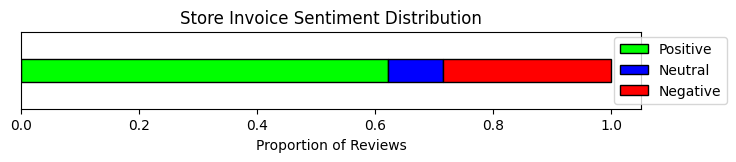

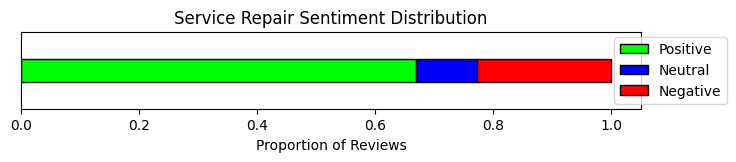

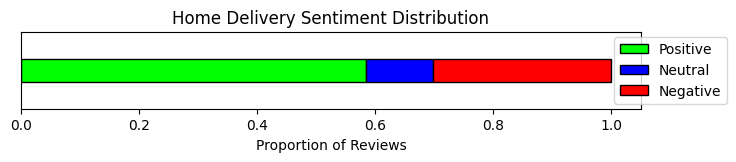

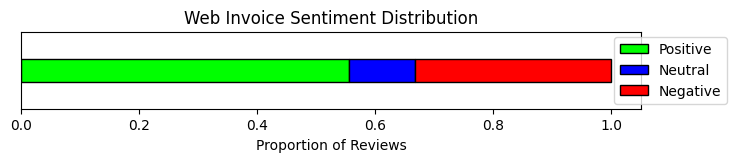

In [24]:
import matplotlib.pyplot as plt

def plot_horizontal_stacked_sentiment_thin(df, title):
    sentiment_order = ['Positive' , 'Neutral', 'Negative']
    colors = {
        
        'Negative': '#FF0000',       # Red
        'Neutral': '#0000FF',        # Blue
        'Positive': '#00FF00',       # Green
        
    }

    counts = df['SENTIMENT'].value_counts().reindex(sentiment_order).fillna(0)
    total = counts.sum()
    fractions = counts / total  # convert counts to fractions for stacked bar

    fig, ax = plt.subplots(figsize=(8, 1)) 

    left = 0
    bar_height = 0.3  

    for sentiment in sentiment_order:
        width = fractions[sentiment]
        ax.barh(0, width, left=left, height=bar_height, color=colors[sentiment], edgecolor='black', label=sentiment)
        left += width

    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    ax.set_xlabel('Proportion of Reviews')
    ax.set_title(title)
    ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))
    plt.show()


plot_horizontal_stacked_sentiment_thin(store_df, 'Store Invoice Sentiment Distribution')
plot_horizontal_stacked_sentiment_thin(service_df, 'Service Repair Sentiment Distribution')
plot_horizontal_stacked_sentiment_thin(home_df, 'Home Delivery Sentiment Distribution')
plot_horizontal_stacked_sentiment_thin(web_df, 'Web Invoice Sentiment Distribution')


In [25]:
def sentiment_summary(df):
    counts = df['SENTIMENT'].value_counts()
    percentages = counts / counts.sum() * 100
    summary = pd.DataFrame({'Count': counts, 'Percentage': percentages.round(2)})
    return summary

print("Store Invoice:")
print(sentiment_summary(store_df), "\n")

print("Service Repair:")
print(sentiment_summary(service_df), "\n")

print("Home Delivery:")
print(sentiment_summary(home_df), "\n")

print("Web Invoice:")
print(sentiment_summary(web_df), "\n")

Store Invoice:
           Count  Percentage
SENTIMENT                   
Positive    1118       62.15
Negative     514       28.57
Neutral      167        9.28 

Service Repair:
           Count  Percentage
SENTIMENT                   
Positive     813       66.91
Negative     276       22.72
Neutral      126       10.37 

Home Delivery:
           Count  Percentage
SENTIMENT                   
Positive     474       58.52
Negative     245       30.25
Neutral       91       11.23 

Web Invoice:
           Count  Percentage
SENTIMENT                   
Positive     192       55.49
Negative     115       33.24
Neutral       39       11.27 



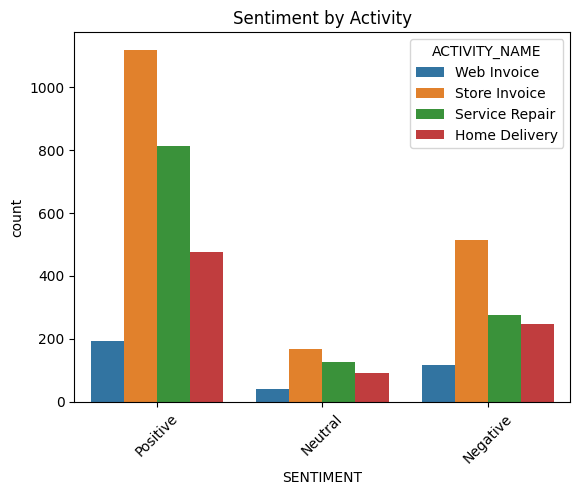

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='SENTIMENT', hue='ACTIVITY_NAME')
plt.title("Sentiment by Activity")
plt.xticks(rotation=45)
plt.show()


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

from nltk.corpus import stopwords
import nltk

stop_words = stopwords.words('english')

def extract_top_keywords(df, sentiment_label, top_n=15):
    texts = df[df['SENTIMENT'] == sentiment_label]['CLEAN_ANSWER'].dropna().tolist()
    
    # Skip if there aren't enough examples
    if len(texts) < 10:
        return [f"Not enough samples for {sentiment_label}"]

    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=1000, ngram_range=(1, 2))
    X = vectorizer.fit_transform(texts)
    
    # Mean TF-IDF scores across all docs
    avg_scores = X.mean(axis=0).A1
    feature_names = vectorizer.get_feature_names_out()

    # Pair & sort
    scored_keywords = sorted(zip(feature_names, avg_scores), key=lambda x: x[1], reverse=True)
    return [kw for kw, score in scored_keywords[:top_n]]


In [29]:
sentiments_to_check = [ 'Positive', 'Neutral', 'Negative']

for sentiment in sentiments_to_check:
    print(f"\nTop keywords in '{sentiment}' reviews:")
    keywords = extract_top_keywords(df, sentiment)
    print(", ".join(keywords))


Top keywords in 'Positive' reviews:
شكرا, good, في, ممتاز, لكم, service, على, شكرا لكم, جدا, staff, كل, من, thanks, التوصيل, خدمة

Top keywords in 'Neutral' reviews:
لا, لايوجد, لا يوجد, يوجد, nothing, شي, لا شي, اقترح, في, شيء, لا شيء, ok, better, من, يكون

Top keywords in 'Negative' reviews:
من, لا, في, غير, لم, على, اكثر, عدم, يتم, ان, التوصيل, المنتج, تم, جدا, ما


In [39]:
insights = {sent: extract_top_keywords(df, sent) for sent in sentiments_to_check}

# Convert to DataFrame
df_keywords = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in insights.items()]))

# Export with UTF-8-BOM encoding to preserve Arabic characters
df_keywords.to_csv("sentiment_keywords.csv", index=False, encoding='utf-8-sig')
